In [216]:
import numpy as np
import matplotlib.pyplot as plt
import csv

In [217]:
data_dir = "../../recorded_sensor_data/mocap_11_17_18-00-00/"
imu_file = data_dir + "mocap_imu_encoder_data.csv"
mocap_file = data_dir + "MQP_FRC_Trial 4.csv"
imu_reader = csv.reader(open(imu_file, 'r'))
mocap_reader = csv.reader(open(mocap_file, 'r'))

# skip headers
next(imu_reader)
next(mocap_reader)
next(mocap_reader)
next(mocap_reader)
next(mocap_reader)
next(mocap_reader)

imu_data = []
for imu_row in imu_reader:
    data = [float(d) for d in imu_row]
    if len(data) > 0 and data[-1] > 1800: # hack to skip first round of data
        imu_data.append(data)
imu_data = np.array(imu_data)

mocap_data = []
for mocap_row in mocap_reader:
    data = [float(d) for d in mocap_row]
    if len(data) > 0:
        mocap_data.append(data)
mocap_data = np.array(mocap_data)

In [218]:
def yawdiff(y1, y2):
    diff = y2 - y1
    if diff > np.pi:
        return diff - np.pi * 2;
    if diff < -np.pi:
        return diff + np.pi * 2;
    return diff;

In [219]:
print("Seconds of IMU data recorded: ", imu_data[-1][-1] - imu_data[0][-1])
print("Seconds of MoCap recorded:", len(mocap_data) / 100)

Seconds of IMU data recorded:  20.88
Seconds of MoCap recorded: 50.27


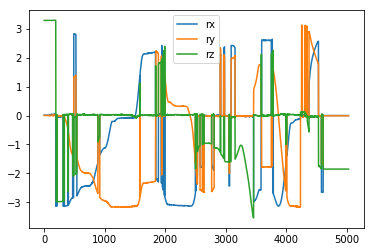

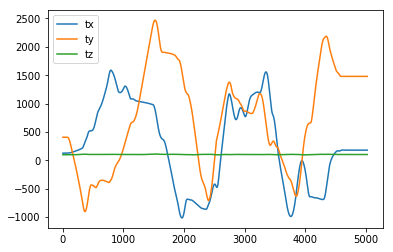

In [5]:
plt.plot(mocap_data[:,2], label="rx")
plt.plot(mocap_data[:,3], label="ry")
plt.plot(mocap_data[:,4], label="rz")
plt.legend()
plt.show()

plt.plot(mocap_data[:,5], label="tx")
plt.plot(mocap_data[:,6], label="ty")
plt.plot(mocap_data[:,7], label="tz")
plt.legend()
plt.show()

In [65]:
states = np.ndarray((mocap_data.shape[0], 9))
state = np.zeros(9)
for mocap_idx in range(1, len(mocap_data)):
    data = mocap_data[mocap_idx]
    last_data = mocap_data[mocap_idx - 1]
    rx = data[2]
    ry = data[3]
    rz = data[4]
    tx = data[5]
    ty = data[6]
    tz = data[7]
    state[0] = tx
    state[1] = ty
    drz = yawdiff(rz, last_data[4]) # handles wrap-around
    state[2] += drz
    states[mocap_idx] = state

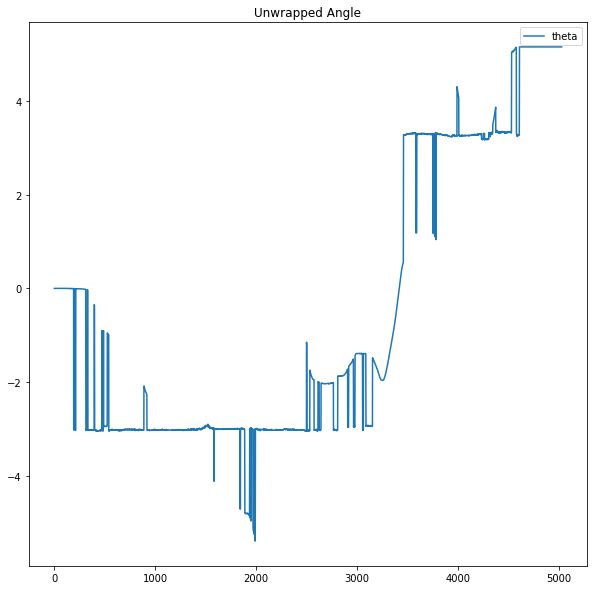

In [214]:
plt.figure(figsize=(10,10))
plt.plot(states[:,2], label='theta')
plt.legend()
plt.title("Unwrapped Angle")
plt.show()

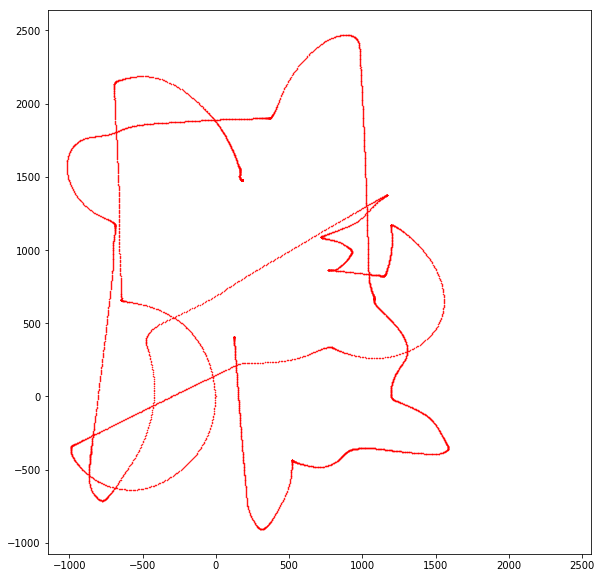

In [215]:
plt.figure(figsize=(10,10))
plt.scatter(states[:,0], states[:,1], marker='.', s=1, color='r')
plt.axis("square")
plt.show()

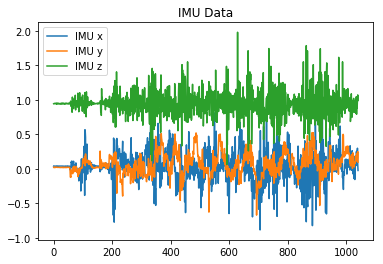

In [80]:
plt.plot(imu_data[:,0], label="IMU x")
plt.plot(imu_data[:,1], label="IMU y")
plt.plot(imu_data[:,2], label="IMU z")
plt.title("IMU Data")
plt.legend()
plt.show()

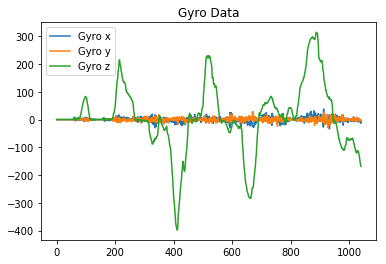

In [81]:
plt.plot(imu_data[:,3], label="Gyro x")
plt.plot(imu_data[:,4], label="Gyro y")
plt.plot(imu_data[:,5], label="Gyro z")
plt.title("Gyro Data")
plt.legend()
plt.show()

In [117]:
means = np.mean(imu_data,axis=0)
print("Average Accel X value:", means[0])
print("Average Accel Y value:", means[1])
print("Average Accel Z value:", means[2])

Average Accel X value: 0.0352497946718
Average Accel Y value: 0.0665275560355
Average Accel Z value: 0.944759155566


In [91]:
yaws = []
yaw = 0
last_t = imu_data[0][-1]
for data in imu_data:
    gyro_z = data[5]
    dt_s = data[-1] - last_t
    yaw += dt_s * gyro_z
    yaws.append(yaw)
    last_t = data[-1]

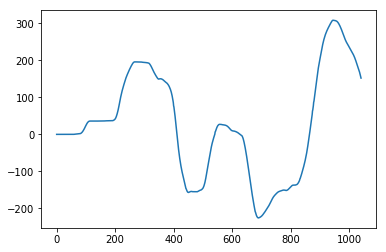

In [92]:
plt.plot(yaws, label="integrated gyro")
plt.show()

In [221]:
x = 0
y = 0
vx = 0
vy = 0
last_t = imu_data[0][-1]
xs = []
ys = []
vxs = []
vys = []
x_bias = 0 #.0385
y_bias = 0 #.041
x_scale = 1000
y_scale = 1000
for data in imu_data:
    ax = (data[0] - x_bias) * x_scale
    ay = (data[1] - y_bias) * y_scale
    dt_s = data[-1] - last_t
    vx += ax * dt_s
    vy += ay * dt_s
    x += vx * dt_s + 0.5 * ax * dt_s ** 2
    y += vy * dt_s + 0.5 * ay * dt_s ** 2
    last_t = data[-1]
    vxs.append(vx)
    vys.append(vy)
    xs.append(x)
    ys.append(y)

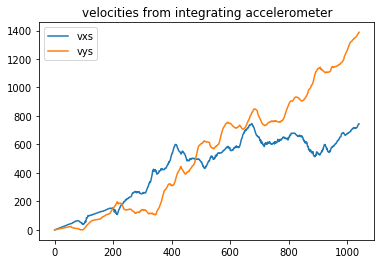

In [222]:
plt.plot(vxs, label="vxs")
plt.plot(vys, label="vys")
plt.title("velocities from integrating accelerometer")
plt.legend()
plt.show()

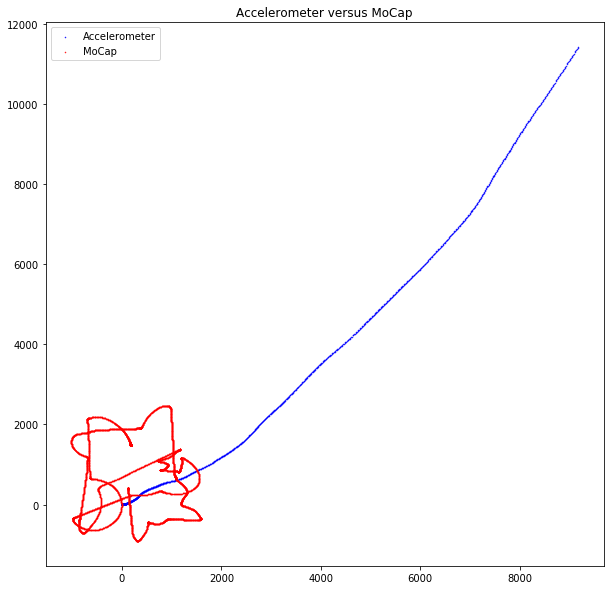

In [223]:
plt.figure(figsize=(10,10))
plt.scatter(xs, ys, marker='.', s=1, color='b', label='Accelerometer')
plt.scatter(states[:,0], states[:,1], marker='.', s=1, color='r', label='MoCap')
plt.title("Accelerometer versus MoCap")
plt.legend()
plt.show()

## Find X/Y accelerometer scales & biases that make the IMU data closest to the other position data